In [1]:
# 此文件系主文件，检测图片请运行此文件

# 组件库
from detector.extract_features import *
from detector.preprocess import *
# 第三方库
import cv2 as cv
import os
import configparser
import time
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
# 设置文件目录
BASE_DIR = r'D:\Documents\Human Detector'
cfg_path = os.path.join(BASE_DIR, 'detector', 'config.cfg')
pos_path = os.path.join(BASE_DIR, 'data', 'train', 'pos')
neg_path = os.path.join(BASE_DIR, 'data', 'train', 'neg')
pred_path = os.path.join(BASE_DIR, 'data', 'predict')

In [3]:
# 读取配置信息
print('正在读取配置信息...')
config = configparser.ConfigParser()
config.read(cfg_path)
size = config.get('detect', 'size')
detector_type = config.get('detect', 'detector_type')
detector_type

正在读取配置信息...


'default'

正在设置特征提取器...
正在设置新人检测器...
正在读取目标图片...


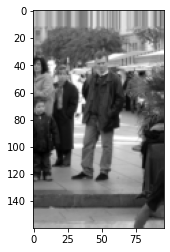

In [22]:
# 设置特征提取器
print('正在设置特征提取器...')
clf = cv.HOGDescriptor()

# 设置行人检测器
print('正在设置新人检测器...')
if detector_type == 'default':
    clf.setSVMDetector(cv.HOGDescriptor_getDefaultPeopleDetector())
elif detector_type == 'daimler':
    clf.setSVMDetector(cv.HOGDescriptor_getDaimlerPeopleDetector())

# 读取图片信息
print('正在读取目标图片...')
file_path = os.path.join(pos_path, 'crop001001a.png')
img = imread(file_path)
graph = img.copy()
graph = cv.cvtColor(graph, cv.COLOR_RGB2GRAY)
plt.imshow(graph, cmap='gray')
plt.show()

正在检测图片中的行人...
[[ 15  10  70 140]]


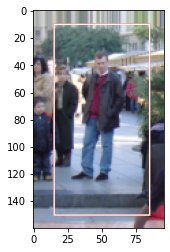

In [25]:
# 检测图片
print('正在检测图片中的行人...')
(windows, cls) = clf.detectMultiScale(graph, winStride=(4, 4), padding=(8, 8), scale=1.1)
print(windows)

# 绘制检测结果
for (x, y, w, h) in windows:
    cv.rectangle(img, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=1)
plt.imshow(img)
plt.show()

In [26]:
"""此文件包含非最大抑制函数"""


def cal_overlap_area(detection_1, detection_2):
    """
    计算两个边界框之间的重叠比例，用于排除重叠区域很高的一些边界框
    由于保证接口的统一性以及置信度的比较，此处的边界框还包含了置信度的信息，在bbox[1]中，有关边框的信息在bbox[0]
    :param detection_1: 第一个边界框
    :param detection_2: 第二个边界框
    :return:
    """
    # 计算x与y方向上的重叠长度
    bbox_1 = detection_1[0]
    bbox_2 = detection_2[0]
    x_start_1 = bbox_1[0]
    x_stop_1 = bbox_1[2]
    y_start_1 = bbox_1[1]
    y_stop_1 = bbox_1[3]
    x_start_2 = bbox_2[0]
    x_stop_2 = bbox_2[2]
    y_start_2 = bbox_2[1]
    y_stop_2 = bbox_2[3]
    x_overlap = max(0, min(x_stop_1, x_stop_2) - max(x_start_1, x_start_2))
    y_overlap = max(0, min(y_stop_1, y_stop_2) - max(y_start_1, y_start_2))
    # 计算重叠区域的面积
    overlap_area = x_overlap * y_overlap
    # 计算并集区域的面积
    total_area = (x_stop_1 - x_start_1) * (y_stop_1 - y_start_1) + \
                 (x_stop_2 - x_start_2) * (y_stop_2 - y_start_2) - overlap_area
    return overlap_area / total_area


def nms(detections, threshold=.5):
    """
    排除置信度较低的边界框
    :param detections: 所有可能的边界框
    :param threshold: 阈值
    :return:
    """
    # 根据置信度对边界框进行排序
    detections = sorted(detections, key=lambda detection: detection[1], reverse=True)
    # 先添加置信度最高的边界框，保证循环的进行
    new_detections = [detections[0]]
    del detections[0]
    # 对边界框进行排除
    for index, detection in enumerate(detections):
        for new_detection in new_detections:
            if cal_overlap_area(detection, new_detection) > threshold:
                break
        else:
            new_detections.append(detection)
    return new_detections


In [27]:
bbox1 = ([140,  80,  63, 126], 1.22057078871876)
bbox2 = ([262,  68,  55, 117], 1.7268787613138556)

In [28]:
cal_overlap_area(bbox1, bbox2)

-0.0